## Лабораторна робота №1

**Тема**: Навчання з підкріпленням на основі середовища Frozen Lake бібліотеки Gymnasium.

Методи динамічного програмування та часової різниці (Temporal-Difference)

**Виконав:** студент групи КМ-12 Пономаренко Олександр

***Підгрупа №3***

#### 0. Встановити бібліотеку [Gymnasium](https://gymnasium.farama.org)

In [1]:
# !pip install gymnasium

Імпорти:

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve
from prettytable import PrettyTable
from time import sleep

Налаштування стилю графіків

In [3]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

#### 1. Ознайомитись з описом середовища [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

Створюємо середовище Frozen Lake 4x4 з вимкненою сковзкістю

In [70]:
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode="human")

Огляд початкової конфігурації середовища

In [71]:
state = env.reset()
print("Початковий стан:", state)
for _ in range(25): env.render()

Початковий стан: (0, {'prob': 1})


Спостерігаємий простір (простір усіх можливих станів), є дискретним:

In [6]:
env.observation_space

Discrete(16)

як видно, він налічує 16 можливих станів (нумеруватимемо їх від 0 до 15), оскільки середовище було створено з мапою 4х4

In [7]:
env.observation_space.n

16

Дії (переходи у інші можливі стани) нумеруються наступним чином:

<img src="actions.png" width="200" height="200">

Розглянемо динаміку середовища, задану за замовчуванням:

In [8]:
dynamics = env.unwrapped.P

In [9]:
table = PrettyTable()
table.field_names = ["State", "Action", "Next State", "Probability", "Reward", "Is Terminal"]

for state, actions in dynamics.items():
    for i, (action, transitions) in enumerate(actions.items()):
        for prob, next_state, reward, done in transitions:
            table.add_row([state if i % 4 == 0 else '', action, next_state, prob, float(reward), done])

print(table)

+-------+--------+------------+-------------+--------+-------------+
| State | Action | Next State | Probability | Reward | Is Terminal |
+-------+--------+------------+-------------+--------+-------------+
|   0   |   0    |     0      |     1.0     |  0.0   |    False    |
|       |   1    |     4      |     1.0     |  0.0   |    False    |
|       |   2    |     1      |     1.0     |  0.0   |    False    |
|       |   3    |     0      |     1.0     |  0.0   |    False    |
|   1   |   0    |     0      |     1.0     |  0.0   |    False    |
|       |   1    |     5      |     1.0     |  0.0   |     True    |
|       |   2    |     2      |     1.0     |  0.0   |    False    |
|       |   3    |     1      |     1.0     |  0.0   |    False    |
|   2   |   0    |     1      |     1.0     |  0.0   |    False    |
|       |   1    |     6      |     1.0     |  0.0   |    False    |
|       |   2    |     3      |     1.0     |  0.0   |    False    |
|       |   3    |     2      |   

Варто звернути увагу на те, що винагороди за переходи у звичайні стани і у негативні термінальні стани **оцінюються як 0**, а перехід у позитивний термінальний стан **має нагороду 1**. 

#### 2. Обчислити функцію ціни стану $v_{π_1}(s)$ для рівноймовірної (випадкової) стратегії $π_1$ при параметрі $𝛾$ = 0,75:
>   **a. за допомогою ітераційного алгоритму Оцінювання стратегії (Policy Evaluation).**

>   **b. за допомогою розв'язання системи рівнянь Белмана для функції ціни стану відносно невідомих значень $x_i = v_{π_1}(s_i)$**

#### Вивести отримані значення у вигляді матриці або теплової карти. 
#### Чи бачите Ви можливі шляхи до покращення рівноймовірної стратегії?

Спочатку задамо рівноймовірну стратегію (кожна дія має однакову ймовірність)

Створюємо матрицю розміром 16х4 (16 можливих станів, у кожному стані можливі 4 дії), заповнюємо її одиницями, а потім елементи кожного рядка ділимо на кількість можливих дій (n from action space):

In [10]:
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

In [11]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Побудуємо ітераційний алгоритм оцінювання стратегії:

In [12]:
def policy_evaluation(env, policy, gamma=0.75, theta=1e-6, output=True):
    # Ініціалізуємо значення функції ціни стану нулями
    V = np.zeros(env.observation_space.n)
    
    # Отримуємо доступ до реального середовища
    env = env.unwrapped

    # Робимо ітерації (одна ітерація проходиться по всій мапі)
    # до тих пір, поки найбільша зміна серед нових станів у порівнянні
    # зі старими станами, не стане менша за задану точність theta
    while True:
        delta = 0  # Відстежуємо зміни у значеннях V для зупинки
        for s in range(env.observation_space.n):
            v = 0
            # Проходимо всі можливі дії
            for a, action_prob in enumerate(policy[s]):
                # для кожного стану s ми беремо по черзі кожну можливу дію,
                # стан, у який нас приведе ця дія (V[next_state]), винагороду
                # за перехід у цей стан і власне ймовірність дії та ймовірність
                # переходу, та використовуємо їх у формулі
                for prob, next_state, reward, _ in env.P[s][a]:
                    v += action_prob * prob * (reward + gamma * V[next_state])
                    
            delta = max(delta, abs(v - V[s]))
            V[s] = v
            
        if output: print(V.round(3).reshape((4,4)))
        
        if delta < theta:  # Якщо зміни досить малі, виходимо з циклу
            break
    return V

<img src="policy evaluation.png" width="600" height="300">

Матриця значень для функції ціни стану спочатку ініціалізується нульовими значеннями.

Далі, ми проходимося по усіх станах, для кожного стану ми переглядаємо усі можливі дії і рахуємо за формулою значення v для поточного стану s.

На найпершій ітерації першим заповнюється передостаннє значення, оскільки у дужці (reward + gamma * V\[next_state]) для всіх інших станів нагорода, що буде отримана за перехід у наступний стан, є нульовою (хоч це звичайний перехід, хоч перехід у негативний термінальний стан). Ненульовою є нагорода лише для позитивного термінального стану, у який можливо перейти лише з передостанньої клітинки.

Далі, оскільки значення у передостанній клітинці вже ненульове, то ненульовими стають значення, з яких можна перейти у цю клітинку і т.д.

Обчислюємо функцію ціни стану для рівноймовірної стратегії:

In [13]:
V = policy_evaluation(env, policy)

[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.25 0.  ]]
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.047 0.   ]
 [0.    0.047 0.314 0.   ]]
[[0.    0.    0.    0.   ]
 [0.    0.    0.009 0.   ]
 [0.    0.018 0.064 0.   ]
 [0.    0.071 0.334 0.   ]]
[[0.    0.    0.002 0.   ]
 [0.    0.    0.012 0.   ]
 [0.003 0.026 0.07  0.   ]
 [0.    0.081 0.341 0.   ]]
[[0.    0.    0.003 0.001]
 [0.001 0.    0.014 0.   ]
 [0.006 0.029 0.072 0.   ]
 [0.    0.085 0.343 0.   ]]
[[0.    0.001 0.003 0.001]
 [0.001 0.    0.014 0.   ]
 [0.007 0.031 0.073 0.   ]
 [0.    0.086 0.344 0.   ]]
[[0.    0.001 0.004 0.001]
 [0.002 0.    0.014 0.   ]
 [0.007 0.031 0.073 0.   ]
 [0.    0.086 0.344 0.   ]]
[[0.001 0.001 0.004 0.001]
 [0.002 0.    0.014 0.   ]
 [0.008 0.031 0.073 0.   ]
 [0.    0.087 0.345 0.   ]]
[[0.001 0.001 0.004 0.001]
 [0.002 0.    0.014 0.   ]
 [0.008 0.031 0.073 0.   ]
 [0.    0.087 0.345 0.   ]]
[[0.001 0.001 0.004 0.001]
 [0.002 

Обрахована матриця для функції ціни стану із заданою точністю $\theta=10^{-6}$ матиме наступний вигляд:

In [14]:
print("Функція ціни стану для рівноймовірної стратегії:\n")
print(V.reshape((4, 4)))

Функція ціни стану для рівноймовірної стратегії:

[[0.00092935 0.00110441 0.00385693 0.00115701]
 [0.0019954  0.         0.0144523  0.        ]
 [0.00771773 0.03144824 0.073222   0.        ]
 [0.         0.08678424 0.34461682 0.        ]]


Складемо тепер з тією ж метою систему рівнянь Белмана для функції ціни стану відносно невідомих значень $x_i = v_{π_1}(s_i)$ за формулою:

<img src="bellman_sle.png" width="600" height="300">

Розглянемо як це працюватиме на прикладі:

<img src="bellman_sle_example.png" width="500" height="250">

Ми склали рівняння функції ціни стану для стану $s_0$. Далі ми розкриваємо дужки у правих частинах і усі доданки, що містять $v_{\pi}$ переносимо у праву частину. У правій частині у нас міститься $v_{\pi}(0)$ з множником 1 і $v_{\pi}(i)$ (i = 1, ..., 15) з множником 0. Ми від відповідних нулів віднімаємо множники перед $v_{\pi}$ які взяли з правої частини. Ці множники це складаються зі значень $prob = p(s', r | s, a) = 1$ і $\gamma = 0.75$. Ми їх беремо відповідно за знаком мінус. І не забуваємо про стратегію $\pi(a|s)$. Через те, що вона рівноймовірна, то можемо просто розділити ті множники на кількість дій з action space.

У правих же частинах (вектор $b$) лишаються значення prob = 1 i r (reward), які ми так само ділимо на кількість можливих дій з action space відповідно до рівноймовірної стратегії

Загалом у нас вийде 16 рівнянь та 16 невідомих (деякі з них зануляться, оскільки ми нікуди не можемо піти з термінальних станів). Тобто таку систему можна вирішити і отримати єдиний розв'язок 

In [15]:
def build_bellman_equations(env, gamma=0.75):
    n_states = env.observation_space.n
    
    A = np.eye(n_states)    # Стартова матриця A (одиниці на діагоналі, бо ми стартуємо з 1 * x_і)
    b = np.zeros(n_states)  # Вектор b

    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    for s in range(n_states):
        for a in range(env.action_space.n):
            for prob, next_state, reward, _ in env.P[s][a]:
                A[s, next_state] -= gamma * prob / env.action_space.n  # Оновлюємо A
                b[s] += prob * reward / env.action_space.n  # Оновлюємо b
    return A, b

In [16]:
A, b = build_bellman_equations(env)

Розв'язуємо систему рівнянь за допомогою scipy.linalg.solve():

In [17]:
V_bellman = solve(A, b)

Виводимо функцію ціни стану, розв'язану через рівняння Белмана

In [18]:
print("Функція ціни стану (розв'язок через рівняння Белмана):")
print(V_bellman.reshape((4, 4)))

Функція ціни стану (розв'язок через рівняння Белмана):
[[0.00093013 0.00110475 0.00385713 0.00115714]
 [0.00199568 0.         0.01445234 0.        ]
 [0.00771784 0.03144827 0.07322202 0.        ]
 [0.         0.08678425 0.34461683 0.        ]]


Візуалізуємо функцію ціни стану через теплову карту

In [19]:
def plot_value_function(V, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(V.reshape((4,4)),  
                annot=True,       # відображення значень на клітинках мапи
                cmap="coolwarm",  # тип теплової мапи
                cbar=True)        # стовпчик з градацією кольорів
        
    plt.title(title)
    plt.show()

Виводимо функцію ціни стану для обох методів

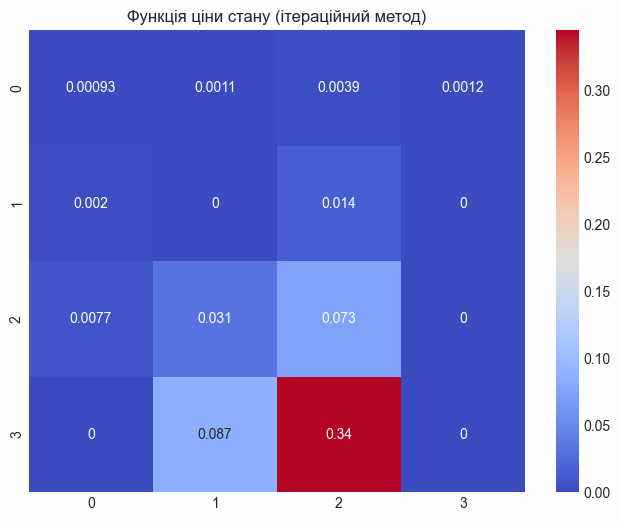

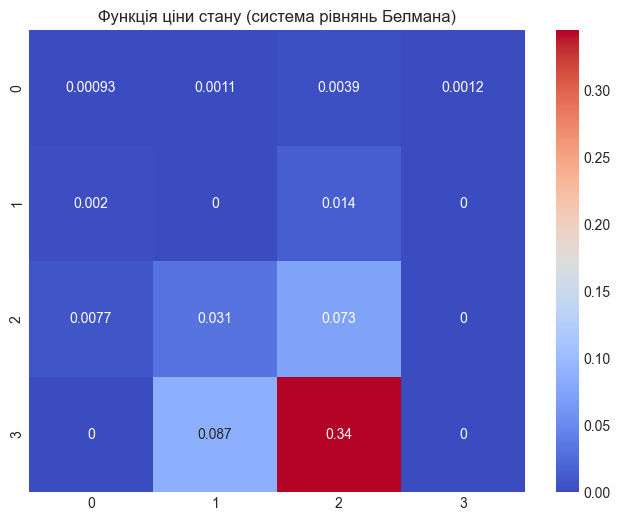

In [20]:
plot_value_function(V, "Функція ціни стану (ітераційний метод)")
plot_value_function(V_bellman, "Функція ціни стану (система рівнянь Белмана)")

**Можливі шляхи до покращення рівноймовірної стратегії**

Як ми бачили з того ж ітераційного алгоритму оцінювання стратегії, на кожній ітерації ми отримуємо більше інформації про сподівану майбутню винагороду для поточного стану та уточнюємо існуючі. Одним зі способів покращення рівноймовірної стратегії є інтегрування жадібної стратегії, де ми змінюємо ймовірності стратегії для кожного стану індивідуально, надаючи перевагу тим діям, що приведуть в сусідню клітинку з найбільшою сподіваною винагородою. При цьому важливо зробити додаткові зміни, які дадуть з передостанньої клітинки перейти у цільовий стан (у поточному варіанті це неможливо, оскільки значення функції ціни для цільового стану є нульовим).

#### 3. Використовуючи знайдені значення функції ціни стану $v_{π_1}(s)$ та рівняння Белмана для функції ціни дії-стану, оцінити функцію ціни дії-стану $q_{π_1}(s_j, a_j)$.

На основі вже сформованої матриці значень функції ціни стану, користуючись умовами узгодженості 

між функцією ціни стану-дії та функцією ціни стану, обчислимо $q_{\pi}(s, a)$ за формулою:

<img src="consistensy condition.png" width="500" height="250">

Оскільки для кожного стану (а їх у нас 16) функція ціни стану-дії відображає ціну дії $a$ в рамках стратегії $\pi$, а дій у нас для кожного стану 4, то у результаті ми очікуємо побачити матрицю розмірністю 16x4, де рядкам відповідають стани, а стовпцям - дії від 0 до 3

In [21]:
def compute_q_values(env, V, gamma=0.75):
    """
    Обчислення функції ціни дії-стану q(s, a) на основі функції ціни стану V(s).
    
    Параметри:
    - env: середовище Gymnasium (Frozen Lake).
    - V: значення функції ціни стану.
    - gamma: коефіцієнт дисконтування (γ).
    
    Повертає:
    - q_values: матриця розміром [кількість станів, кількість дій] для q(s, a).
    """
    
    # Отримуємо доступ до реального середовища
    env = env.unwrapped
    
    # Ініціалізуємо матрицю функції ціни дії-стану нулями
    q_values = np.zeros((env.observation_space.n, env.action_space.n))
    
    # Обчислюємо значення q(s, a) для кожної пари стану та дії
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            q_sa = 0  # Початкове значення для q(s, a)
            # Проходимо всі можливі наступні стани та ймовірності переходів
            for prob, next_state, reward, done in env.P[s][a]:
                # Обчислюємо значення q(s, a) через рівняння Белмана
                q_sa += prob * (reward + gamma * V[next_state])
            q_values[s, a] = q_sa
    
    return q_values

Обчислюємо функцію ціни дії-стану на основі знайденої функції ціни стану V

In [22]:
q_values = compute_q_values(env, V)

Виводимо функцію ціни дії-стану

In [23]:
print("Функція ціни дії-стану q(s, a) для рівноймовірної стратегії:\n")
print(q_values)

Функція ціни дії-стану q(s, a) для рівноймовірної стратегії:

[[6.97012896e-04 1.49654653e-03 8.28310221e-04 6.97012896e-04]
 [6.97012896e-04 0.00000000e+00 2.89269824e-03 8.28310221e-04]
 [8.28310221e-04 1.08392220e-02 8.67754265e-04 2.89269824e-03]
 [2.89269824e-03 0.00000000e+00 8.67754265e-04 8.67754265e-04]
 [1.49654653e-03 5.78829705e-03 0.00000000e+00 6.97012896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49165009e-02 0.00000000e+00 2.89269824e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.78829705e-03 0.00000000e+00 2.35861771e-02 1.49654653e-03]
 [5.78829705e-03 6.50881771e-02 5.49165009e-02 0.00000000e+00]
 [2.35861771e-02 2.58462616e-01 0.00000000e+00 1.08392220e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.50881771e-02 2.58462616e-01 2.35861771e-02]
 [6.50881771e-02 2.58462616e-01 1.00000000e+00 5.4916500

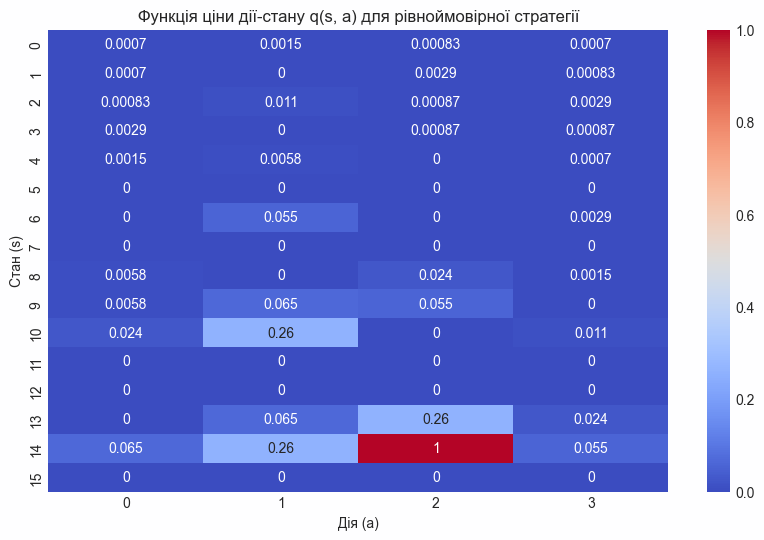

In [24]:
def plot_q_values(q_values, title="Функція ціни дії-стану q(s, a)"):
    """
    Візуалізація функції ціни дії-стану q(s, a).
    """
    plt.figure(figsize=(10,6))
    sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.xlabel("Дія (a)")
    plt.ylabel("Стан (s)")
    plt.show()

# Візуалізуємо функцію ціни дії-стану
plot_q_values(q_values, "Функція ціни дії-стану q(s, a) для рівноймовірної стратегії")

#### 4. Створити функцію $equiprobable$, результатом якої є номер дії. Дія обирається випадковим чином з множини допустимих дій.

In [25]:
def equiprobable(env):
    """
    Функція, яка обирає випадкову дію з множини допустимих дій у середовищі.
    
    Параметри:
    - env: середовище Gymnasium
    
    Повертає:
    - action: випадково вибрана дія
    """
    # Вибираємо випадкову дію з множини можливих дій
    action = np.random.choice(env.action_space.n)
    return action

Викликаємо функцію $equiprobable$ для випадкового вибору дії

In [27]:
for _ in range(4): print("Випадково вибрана дія:", equiprobable(env))

Випадково вибрана дія: 2
Випадково вибрана дія: 1
Випадково вибрана дія: 3
Випадково вибрана дія: 0


#### 5. Створити функцію $get$_$episode$, яка приймає у якості аргументу екземпляр середовища, а результатом функції є епізод, тобто список кортежів, кожен з яких зберігає всі характеристики кожного кроку агента (тобто попередній стан, дію, винагороду, поточний стан, значення параметрів terminated та truncated). Вибір агентом дії у кожному стані на даному етапі реалізуйте на основі функції $equiprobable$, або, іншими словами, на основі рівноймовірної (випадкової) стратегії $π_1$.

Додаткова інформація з документації:

$terminated (bool)$ – чи досягає агент термінального стану. Наприклад, це може бути досягнення цільового стану або потрапляння в лунку. Якщо значення true, користувачеві необхідно викликати функцію reset().

$truncated (bool)$ – чи виконана умова усічення. Зазвичай це обмеження за часом, але також може вказувати на вихід агента за фізичні межі середовища (**у нас це обмеження за часом**: [Truncated is for time-limits **when time is not part of the observation space**](https://www.reddit.com/r/reinforcementlearning/comments/15q3weo/comment/jw0va8q/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button)). Це можна використовувати для передчасного завершення епізоду до досягнення термінального стану. Якщо значення true, користувачеві необхідно викликати функцію reset().

In [28]:
def get_episode(env, output=False):
    """
    Функція, яка генерує епізод гри у середовищі, базуючись на рівноймовірній стратегії.
    
    Параметри:
    - env: середовище Gymnasium
    
    Повертає:
    - episode: список кортежів, кожен з яких зберігає інформацію про (стан, дію, винагороду, новий стан, terminated, truncated)
    """
    # Ініціалізуємо середовище і отримуємо початковий стан
    state = env.reset()[0]  # Перший елемент результату env.reset() - це початковий стан (0)
    episode = []  # Список для зберігання кортежів
    terminated = False
    truncated = False

    if output: env.render(); sleep(3)

    # Поки епізод не завершено
    while not terminated and not truncated:
        # Обираємо дію на основі рівноймовірної стратегії
        action = equiprobable(env)
        
        # Виконуємо дію в середовищі
        next_state, reward, terminated, truncated, *_ = env.step(action)
        
        # Зберігаємо кортеж (попередній стан, дія, винагорода, новий стан, terminated, truncated)
        episode.append((state, action, reward, next_state, terminated, truncated))

        # Виводимо інформацію про поточний крок
        if output:
            print(f"Крок: стан={state}, дія={action}, винагорода={reward}, новий стан={next_state}, terminated={terminated}, truncated={truncated}")
        
        # Переходимо до нового стану
        state = next_state

    return episode

Викликаємо функцію для отримання епізоду

In [29]:
episode = get_episode(env, output=True)
print("\nЕпізод:")
for step in episode:
    print(step)

Крок: стан=0, дія=0, винагорода=0.0, новий стан=0, terminated=False, truncated=False
Крок: стан=0, дія=3, винагорода=0.0, новий стан=0, terminated=False, truncated=False
Крок: стан=0, дія=2, винагорода=0.0, новий стан=1, terminated=False, truncated=False
Крок: стан=1, дія=3, винагорода=0.0, новий стан=1, terminated=False, truncated=False
Крок: стан=1, дія=3, винагорода=0.0, новий стан=1, terminated=False, truncated=False
Крок: стан=1, дія=1, винагорода=0.0, новий стан=5, terminated=True, truncated=False

Епізод:
(0, 0, 0.0, 0, False, False)
(0, 3, 0.0, 0, False, False)
(0, 2, 0.0, 1, False, False)
(1, 3, 0.0, 1, False, False)
(1, 3, 0.0, 1, False, False)
(1, 1, 0.0, 5, True, False)


#### 6. Виконати 100 епізодів за допомогою функції $get$_$episode$. Виведіть на екран два графіки: винагорода та тривалість епізоду.

In [30]:
def run_episodes(env, num_episodes=100):
    rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        episode = get_episode(env)
        total_reward = sum([step[2] for step in episode])  # Сума винагород у епізоді
        episode_length = len(episode)                      # Тривалість епізоду
        
        rewards.append(total_reward)
        episode_lengths.append(episode_length)
    
    return rewards, episode_lengths

Перестворимо середовище вже без параметра render_mode, щоб 100 епізодів не відображались 

графічно у користувацькому вікні і 100 епізодів виконались майже миттєво:

In [31]:
env.close()
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)

Запуск 100 епізодів

In [35]:
num_episodes = 100
rewards, episode_lengths = run_episodes(env, num_episodes)

In [36]:
def plot_episodes(num_episodes, policy, rewards, episode_length, ticks=False):
    plt.figure(figsize=(12, 5))
    
    # Дані для графіків
    data = [(rewards, 'Винагорода', '#3BA3A5'), 
            (episode_length, 'Тривалість (кроки)', '#1C7FB0')]
    
    for i, (values, ylabel, color) in enumerate(data, 1):
        plt.subplot(1, 2, i)
        plt.plot(range(1, num_episodes + 1), values, label=f'{ylabel} ({policy})', color=color)
        plt.xlabel('Епізод')
        plt.ylabel(ylabel)
        if ticks: plt.xticks(range(1, num_episodes + 1))
        plt.title(f'{ylabel} за епізод ({policy})')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

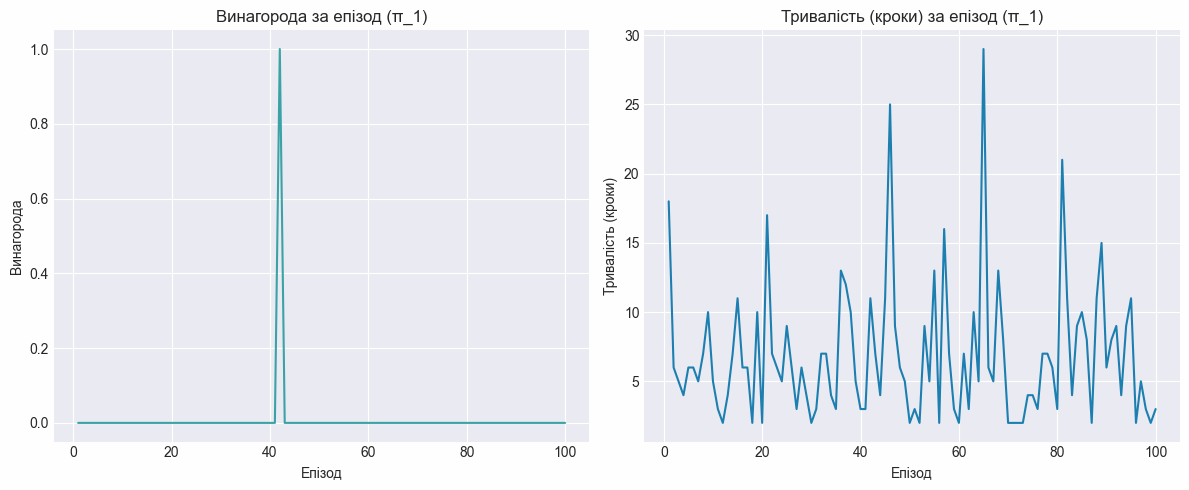

In [37]:
plot_episodes(num_episodes, 'π_1', rewards, episode_lengths)

#### 7. Реалізувати метод Ітерації ціни (Value Iteration) для знаходження оптимальної стратегії за заданою початковою.

Згідно методу Ітерації Ціни, для кожного стану знаходиться вартість кожної дії у цьому стані і серед знайдених вартостей дій обирається максимальне значення. Це значення і стає оптимальним значенням функції ціни стану $v_*$ для поточного стану $s$. Дана процедура задається наступним рівнянням оптимальності Белмана для функції ціни стану:

<img src="bellman_value-state_optimality.png" width="500" height="250">

Алгоритм Value Iteration:

<img src="value_iteration_algorithm.png" width="800" height="400">

Після того, як була отримана функція $v_*(s)$ $\forall s$, оптимальна стратегія обирається за наступним принципом: для кожного стану оптимальна стратегія $\pi_*$ робитиме перехід у стан $s'$ за дією $a$ такою, що має найбільшу вартість переходу.

In [38]:
def value_iteration(env, V_initial=None, gamma=0.75, theta=1e-6):
    """
    Реалізація методу Ітерації ціни (Value Iteration) для знаходження оптимальної стратегії.
    
    Параметри:
    - env: середовище Gymnasium (Frozen Lake).
    - gamma: коефіцієнт дисконтування (γ).
    - theta: поріг для перевірки збіжності.

    Повертає:
    - V: оптимальна функція ціни стану.
    - policy: оптимальна стратегія для кожного стану.
    """
    
    V = V_initial.copy() if V_initial is not None else np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)

    env = env.unwrapped

    while True:
        delta = 0  # Відстежуємо максимальні зміни у функції ціни стану
        for s in range(env.observation_space.n):
            v = V[s]  # Зберігаємо поточне значення функції ціни стану
            
            # Оцінюємо значення функції ціни дії-стану для кожної дії
            action_values = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for prob, next_state, reward, _ in env.P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_state])
            
            V[s] = max(action_values)  # Оновлюємо V(s) як максимальне значення серед дій
            delta = max(delta, abs(v - V[s]))  # Оновлюємо максимальне відхилення

        # Перевірка на збіжність
        if delta < theta: break

    # Визначення оптимальної стратегії після збіжності
    for s in range(env.observation_space.n):
        action_values = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, _ in env.P[s][a]:
                action_values[a] += prob * (reward + gamma * V[next_state])
        policy[s] = np.argmax(action_values)  # Вибір дії з максимальним значенням

    return V, policy

Викликаємо функцію Ітерації ціни

In [39]:
optimal_values, optimal_policy = value_iteration(env)

Виведення результатів

In [40]:
print("Оптимальна функція ціни стану V(s):")
print(optimal_values.reshape((4, 4)))

print("\nОптимальна стратегія π(s):")
print(optimal_policy.reshape((4, 4)))

Оптимальна функція ціни стану V(s):
[[0.23730469 0.31640625 0.421875   0.31640625]
 [0.31640625 0.         0.5625     0.        ]
 [0.421875   0.5625     0.75       0.        ]
 [0.         0.75       1.         0.        ]]

Оптимальна стратегія π(s):
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


#### 8. Оцінити оптимальну стратегію $π_*$ та функцію ціни стану $v_*(s)$ для заданого середовища за допомогою методу Ітерації ціни, використовуючи в якості початкових параметрів стратегію $π_1$ та функцію ціни $v_{π_1}(s)$. Порівняйте отриману функцію ціни $v_*(s)$ з функцією $v_{π_1}(s)$ з задання №2.

Нагадування, як виглядає змінна $policy$:

In [41]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [42]:
# Оцінка функції ціни стану для випадкової стратегії π_1 з пункту 2 (результат з policy_evaluation)
V_random_policy = policy_evaluation(env, policy, output=False)

In [43]:
print("Функція ціни стану для випадкової стратегії π_1 з пункту 2:")
print(V_random_policy.reshape((4, 4)))

Функція ціни стану для випадкової стратегії π_1 з пункту 2:
[[0.00092935 0.00110441 0.00385693 0.00115701]
 [0.0019954  0.         0.0144523  0.        ]
 [0.00771773 0.03144824 0.073222   0.        ]
 [0.         0.08678424 0.34461682 0.        ]]


Взагалі оптимальна функція ціни стану не залежить від початкової стратегії і, відповідно, початкової матриці зі значеннями функції $v_{\pi_1}$, оскільки у неї беруться максимальні значення з $action\_values$ у кожному стані, і стратегія тут ні до чого, але упустимо цей момент, і покажемо явно передачу $V\_random\_policy$ у $V\_initial$ при виклику функції $value\_iteration$:

In [45]:
# Використовуємо метод Ітерації ціни для знаходження оптимальної стратегії та функції ціни стану
V_optimal, optimal_policy = value_iteration(env, V_initial=V_random_policy)

Порівнюємо функції ціни стану

In [46]:
print("Функція ціни стану для випадкової стратегії π_1:")
print(V_random_policy.reshape((4, 4)))

print("\nОптимальна функція ціни стану V*(s):")
print(V_optimal.reshape((4, 4)))

Функція ціни стану для випадкової стратегії π_1:
[[0.00092935 0.00110441 0.00385693 0.00115701]
 [0.0019954  0.         0.0144523  0.        ]
 [0.00771773 0.03144824 0.073222   0.        ]
 [0.         0.08678424 0.34461682 0.        ]]

Оптимальна функція ціни стану V*(s):
[[0.23730469 0.31640625 0.421875   0.31640625]
 [0.31640625 0.         0.5625     0.        ]
 [0.421875   0.5625     0.75       0.        ]
 [0.         0.75       1.         0.        ]]


Побудуємо графіки для порівняння функцій ціни стану

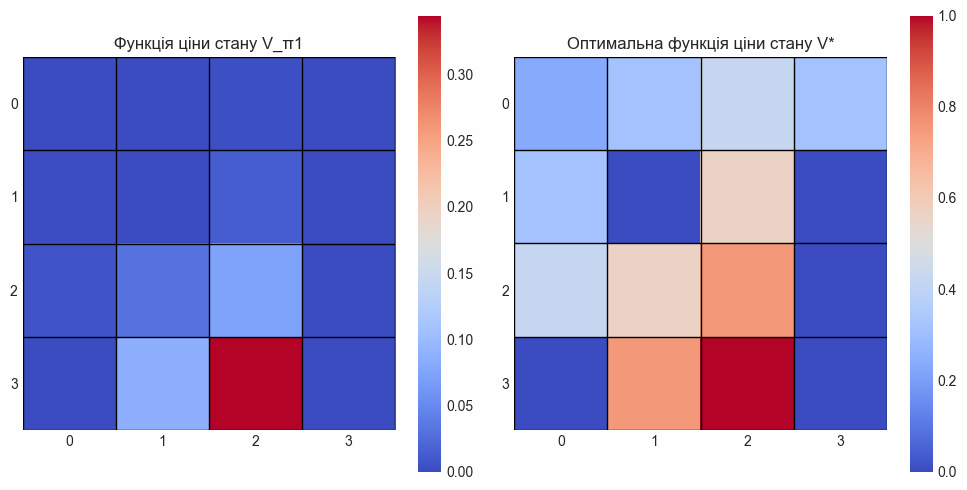

In [47]:
plt.figure(figsize=(10, 5))

v_values = [V_random_policy, V_optimal]
v_policies = ['V_π1', 'V*']

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(v_values[i].reshape((4, 4)), cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title(f"{['Функція', 'Оптимальна функція'][i]} ціни стану {v_policies[i]}")
    plt.xticks(ticks=np.arange(4), labels=np.arange(4))
    plt.yticks(ticks=np.arange(4), labels=np.arange(4))
    
    plt.gca().set_xticks(np.arange(-0.5, 4, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, 4, 1), minor=True)
    plt.grid(which="minor", color="black", linestyle='-', linewidth=1)
    plt.gca().tick_params(which="minor", size=0)
    plt.grid(False)
    for spine in plt.gca().spines.values(): spine.set_visible(False)

plt.tight_layout()
plt.show()

#### 9. Виконати 15 епізодів за допомогою функції $get$_$episode$ зі стратегією $π_*$. Виведіть на екран два графіки: винагорода та тривалість епізоду. Порівняйте результати з відповідними результатами завдання №6.

In [48]:
# Функція для отримання епізоду з використанням оптимальної стратегії
def get_episode_optimal(env, q_values):
    episode = []
    state, info = env.reset()  # reset повертає стан і інформацію
    done = False
    
    while not done:
        # Вибір дії на основі Q-значень: обираємо дію з максимальною Q-цінністю
        action = np.argmax(q_values[state])  # Оптимальна дія
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, next_state, terminated or truncated))
        state = next_state  # оновлюємо стан
        done = terminated or truncated
    
    return episode

# Функція для запуску епізодів з оптимальною стратегією
def run_optimal_episodes(env, q_values, num_episodes=15):
    rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        episode = get_episode_optimal(env, q_values)
        total_reward = sum([step[2] for step in episode])  # Сума винагород у епізоді
        episode_length = len(episode)  # Тривалість епізоду
        
        rewards.append(total_reward)
        episode_lengths.append(episode_length)
    
    return rewards, episode_lengths

Виконаємо 15 епізодів за допомогою оптимальної стратегії $π_*$

In [49]:
num_episodes = 15
optimal_rewards, optimal_episode_lengths = run_optimal_episodes(env, q_values)

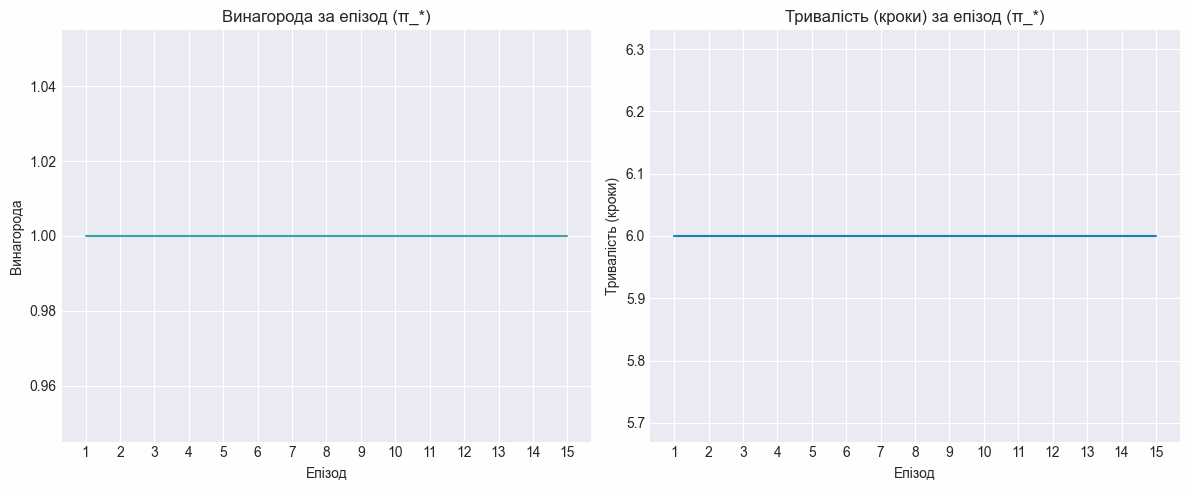

In [50]:
plot_episodes(num_episodes, 'π_*', optimal_rewards, optimal_episode_lengths, ticks=True)

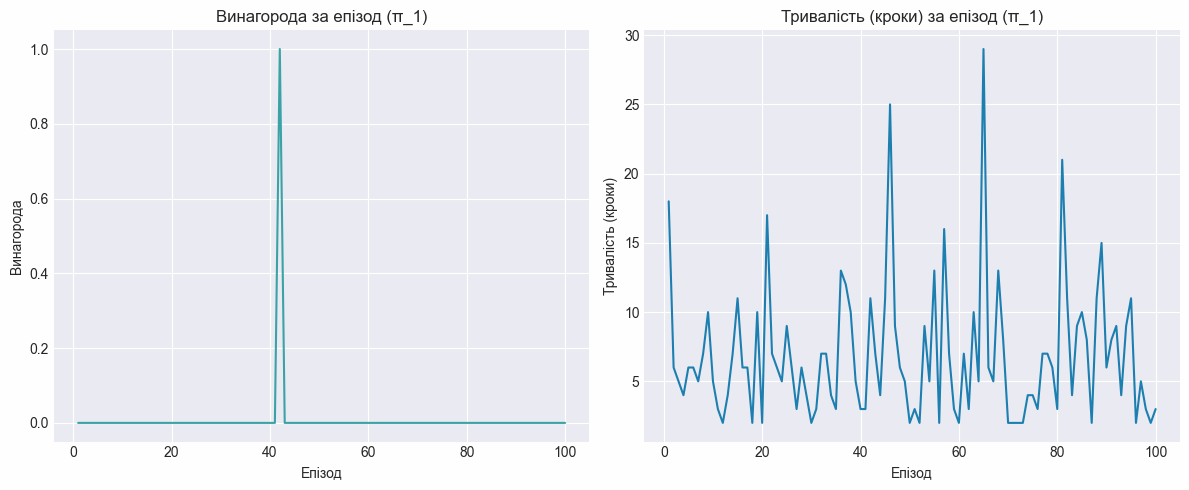

In [51]:
plot_episodes(100, 'π_1', rewards, episode_lengths)

Як бачимо, за оптимальної стратегії позитивний термінальний стан досягається на кожному епізоді і рівно за 6 кроків (найменша можлива і оптимальна кількість).

Рівноймовірна стратегія досягає позитивного термінального стану лише в одному зі 100 епізодів, а тривалість епізодів варіюється випадковим чином в залежності від швидкості потрапляння у лунку (негативний термінальний стан).

#### 10. Використовуючи знайдені значення оптимальної функції ціни стану $v_*(s)$ та рівняння Белмана для функції ціни дії-стану, оцінити оптимальну функцію ціни дії-стану $q_*(s_j, a_j)$. Порівняйте результати з результатами завдання №3.

Рівняння оптимальності Белмана для функції ціни дії-стану:

<img src="optimal_action_value_state_function.png" width="500" height="250">

Функція для оцінки оптимальної функції ціни дії-стану $q_*(s, a)$:

In [52]:
def compute_optimal_q_values(env, v_optimal, gamma=0.75):
    q_star = np.zeros((env.observation_space.n, env.action_space.n))

    env = env.unwrapped
    
    for s in range(env.observation_space.n):  # для кожного стану
        for a in range(env.action_space.n):  # для кожної дії
            for prob, next_state, reward, done in env.P[s][a]:
                q_star[s, a] += prob * (reward + gamma * v_optimal[next_state])
    
    return q_star

In [53]:
optimal_q_values = compute_optimal_q_values(env, V_optimal)

Виведення значень $q_*(s, a)$ у вигляді матриці

In [54]:
print("Оптимальна функція ціни дії-стану q_*(s, a):")
print(optimal_q_values)

Оптимальна функція ціни дії-стану q_*(s, a):
[[0.17797852 0.23730469 0.23730469 0.17797852]
 [0.17797852 0.         0.31640625 0.23730469]
 [0.23730469 0.421875   0.23730469 0.31640625]
 [0.31640625 0.         0.23730469 0.23730469]
 [0.23730469 0.31640625 0.         0.17797852]
 [0.         0.         0.         0.        ]
 [0.         0.5625     0.         0.31640625]
 [0.         0.         0.         0.        ]
 [0.31640625 0.         0.421875   0.23730469]
 [0.31640625 0.5625     0.5625     0.        ]
 [0.421875   0.75       0.         0.421875  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.5625     0.75       0.421875  ]
 [0.5625     0.75       1.         0.5625    ]
 [0.         0.         0.         0.        ]]


Порівняння функцій $q(s, a)$ для випадкової та оптимальної стратегій:

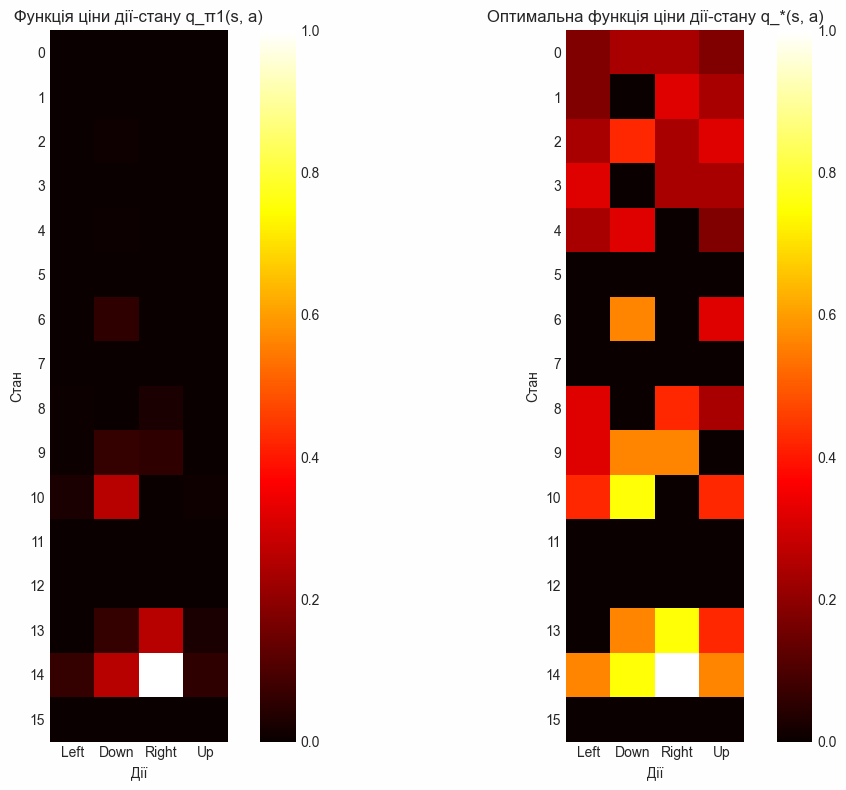

In [55]:
q_values_random_policy = compute_q_values(env, V_random_policy)  # Значення для випадкової стратегії (з завдання №3)

q_vals = [q_values_random_policy, optimal_q_values]
policies = ['q_π1(s, a)', 'q_*(s, a)']

plt.figure(figsize=(12, 8))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(q_vals[i], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f"{['Функція', 'Оптимальна функція'][i]} ціни дії-стану {policies[i]}")
    plt.xlabel("Дії")
    plt.ylabel("Стан")
    plt.xticks(np.arange(env.action_space.n), ['Left', 'Down', 'Right', 'Up'])
    plt.yticks(np.arange(env.observation_space.n))
    plt.grid(False)

plt.tight_layout()
plt.show()

#### 11. Створити функцію $eps$_\$greedy$_$policy$, аргументами якої є масив значень функції ціни дії-стану $q(s, a)$ та параметр $ε$, та результатом є номер дії, обраний з множини номерів допустимих дій за допомогою методу $ε$-жадібної стратегії ($ε$-greedy policy).

Визначення $ε$-жадібної стратегії:

<img src='epsilon_greedy_policy.png' width='700' height='400'>

In [56]:
def eps_greedy_policy(q_values, epsilon):
    # Знаходимо індекси (номери) дій з максимальним значенням функції Q
    max_action = np.argmax(q_values)
    
    # Ініціалізуємо ймовірності для всіх дій
    num_actions = len(q_values)
    probabilities = np.full(num_actions, epsilon / num_actions)
    probabilities[max_action] += 1 - epsilon
    
    # Вибираємо дію згідно з обчисленими ймовірностями
    action = np.random.choice(np.arange(num_actions), p=probabilities)
    
    return action

Розглянемо які дії прийматимуться за $ε$-жадібною стратегією на основі оптимальної функції ціни дії-стану $q_*$:

In [57]:
print(np.array([eps_greedy_policy(optimal_q_values[i], 0.1) for i in range(env.observation_space.n)]).reshape(4,4))

[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


Як можемо бачити, дії, якщо порівняти обрані дії для кожного стану з тепловою картою з минулого завдання, то числа, що кодують дії, у кожному стані відповідають 'найгарячішій' клітинці, тобто клітинці з найбільшою ймовірністю переходу у неї (оскільки вона має найбільше значення q)

#### 12. Реалізувати метод 𝔼-SARSA (Expected SARSA) для знаходження оптимальної функції ціни дії-стану $q_*(s, a)$ за заданою початковою.

<img src="expected_sarsa_algorithm.png" width="800" height="400">

In [58]:
q_values = compute_q_values(env, V)
q_values

array([[6.97012896e-04, 1.49654653e-03, 8.28310221e-04, 6.97012896e-04],
       [6.97012896e-04, 0.00000000e+00, 2.89269824e-03, 8.28310221e-04],
       [8.28310221e-04, 1.08392220e-02, 8.67754265e-04, 2.89269824e-03],
       [2.89269824e-03, 0.00000000e+00, 8.67754265e-04, 8.67754265e-04],
       [1.49654653e-03, 5.78829705e-03, 0.00000000e+00, 6.97012896e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.49165009e-02, 0.00000000e+00, 2.89269824e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.78829705e-03, 0.00000000e+00, 2.35861771e-02, 1.49654653e-03],
       [5.78829705e-03, 6.50881771e-02, 5.49165009e-02, 0.00000000e+00],
       [2.35861771e-02, 2.58462616e-01, 0.00000000e+00, 1.08392220e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.50881771e-02, 2.58462616e

In [59]:
def expected_q_value(Q, epsilon):
    """Обчислення очікуваного значення Q з використанням ε-жадібної стратегії"""
    max_action = np.argmax(Q)
    num_actions = len(Q)
    probabilities = np.full(num_actions, epsilon / num_actions)
    probabilities[max_action] += 1 - epsilon
    return np.dot(probabilities, Q)

def expected_sarsa(env, num_episodes, alpha, gamma, epsilon=0, Q=None, varEps=False):
    """Метод 𝔼-SARSA для обчислення оптимальних значень Q."""
    if Q is None: Q = q_values.copy()
        
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        episode_epsilon = 1 / episode if varEps else epsilon
        
        while not done:
            action = eps_greedy_policy(Q[state], episode_epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Оновлення значення Q з використанням очікуваного значення
            expected_q_next = expected_q_value(Q[next_state], episode_epsilon)
            Q[state, action] += alpha * (reward + gamma * expected_q_next - Q[state, action])
            
            state = next_state  # Переходимо до наступного стану
            
    return Q

In [60]:
env.close()
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False)

#### 13. Оцінити оптимальну функцію ціни дії-стану $q_*(s, a)$ для заданого середовища за допомогою методу 𝔼-SARSA, використовуючи $ε$-жадібну стратегію та функцію ціни дії-стану $q_{π_1}(s, a)$. Використайте дві стратегії задання значення параметра:
> **a. задання постійного значення $ε$ ∈ {0,1 ; 0,5};**

> **b. зміна значення $ε$ за законом $ε(k) = \frac{1}{k}$, де $k ∈ \{1, 2, 3, ..., K\}$, $K$ є кількістю епізодів для навчання.**

#### Порівняйте отримані оцінки функцій $q_*(s, a)$ з функціями $q_{π_1}(s, )$ та $q_*(s, a)$ з завдань №3, №10. Оберіть кращу оцінку функції $q_*(s, a)$ і відповідне їй значення параметра $ε$.

In [61]:
def compare_q_values(q_values_1, q_values_2, q_values_3, q_values_4):
    """
    Функція для порівняння 4 різних q-значень.
    """
    print("Порівняння q-значень:")
    print("q_{π_1}(s, a):")
    print(q_values_1)
    
    print("\nОптимальна функція ціни дії-стану q_*(s, a) з ε=0.1:")
    print(q_values_2)

    print("\nОптимальна функція ціни дії-стану q_*(s, a) з ε=0.5:")
    print(q_values_3)

    print("\nОптимальна функція ціни дії-стану q_*(s, a) зі змінним ε:")
    print(q_values_4)

Параметри для навчання

In [62]:
num_episodes = 100  # Кількість епізодів
alpha = 0.1  # Темп навчання
gamma = 0.75  # Дисконтований фактор

In [63]:
# Виконання E-SARSA з постійним ε
q_values_constant_0_1 = expected_sarsa(env, num_episodes, alpha, gamma, epsilon=0.1)
q_values_constant_0_5 = expected_sarsa(env, num_episodes, alpha, gamma, epsilon=0.5)

# Виконання E-SARSA зі змінним ε
q_values_variable = expected_sarsa(env, num_episodes, alpha, gamma, varEps=True)

Порівняння результатів у сухому вигляді:

In [64]:
compare_q_values(q_values, q_values_constant_0_1, q_values_constant_0_5, q_values_variable)

Порівняння q-значень:
q_{π_1}(s, a):
[[6.97012896e-04 1.49654653e-03 8.28310221e-04 6.97012896e-04]
 [6.97012896e-04 0.00000000e+00 2.89269824e-03 8.28310221e-04]
 [8.28310221e-04 1.08392220e-02 8.67754265e-04 2.89269824e-03]
 [2.89269824e-03 0.00000000e+00 8.67754265e-04 8.67754265e-04]
 [1.49654653e-03 5.78829705e-03 0.00000000e+00 6.97012896e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49165009e-02 0.00000000e+00 2.89269824e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.78829705e-03 0.00000000e+00 2.35861771e-02 1.49654653e-03]
 [5.78829705e-03 6.50881771e-02 5.49165009e-02 0.00000000e+00]
 [2.35861771e-02 2.58462616e-01 0.00000000e+00 1.08392220e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.50881771e-02 2.58462616e-01 2.35861771e-02]
 [6.50881771e-02 2.58462616e-01 1.00000000e+00 5.49165009e-02]
 [0.00000000e+00 0

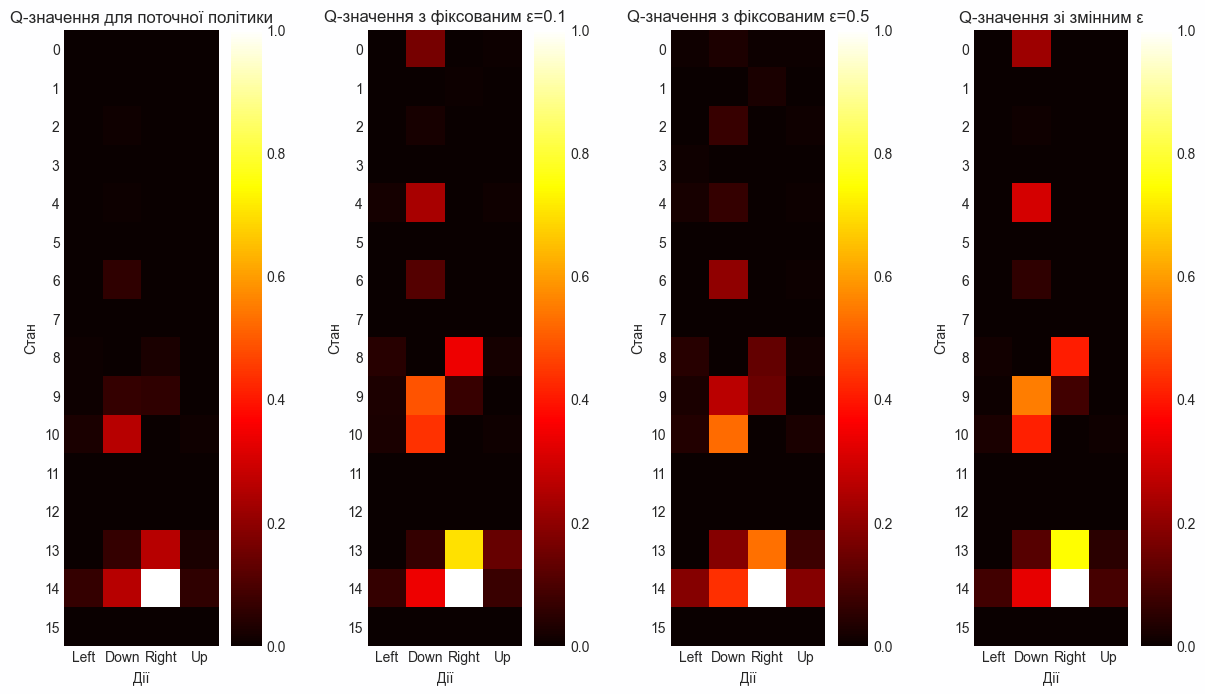

In [65]:
plt.figure(figsize=(15, 8))

# Всі варіанти q-значень та відповідні заголовки
q_values_list = [q_values, q_values_constant_0_1, q_values_constant_0_5, q_values_variable]
titles = [
    "Q-значення для поточної політики",
    "Q-значення з фіксованим ε=0.1",
    "Q-значення з фіксованим ε=0.5",
    "Q-значення зі змінним ε"
]

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(q_values_list[i], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(titles[i])
    plt.xlabel("Дії")
    plt.ylabel("Стан")
    plt.xticks(np.arange(env.action_space.n), ['Left', 'Down', 'Right', 'Up'])
    plt.yticks(np.arange(env.observation_space.n))
    plt.grid(False)

plt.show()

Вибір кращої оцінки функції $q_*(s, a)$, або ж оптимальної функції ціни дії-стану, ґрунтується на пошуку значень, що максимально наближені до справжніх оптимальних значень $q_*(s, a)$ у кожному стані $s$ і для кожної дії $a$. Основний принцип полягає у використанні максимізації значень оцінки функції $q(s, a)$ у довгостроковій перспективі.

Різні значення параметра $\epsilon$ (ступеня випадковості) впливають на стратегію дослідження та експлуатації:
- При малих значеннях $\epsilon$ (наприклад, $\epsilon = 0.1$), алгоритм більше фокусується на експлуатації отриманих знань, що призводить до більш стабільних та відносно високих значень $q(s, a)$.
- При високих значеннях $\epsilon$ (наприклад, $\epsilon = 0.5$), алгоритм віддає перевагу дослідженню нових станів і дій, що може призвести до менш стабільних, але іноді кращих у загальному значень $q(s, a)$.
- Змінне $\epsilon$  дозволяє початкове дослідження з поступовим переходом до експлуатації, що часто сприяє досягненню балансу між обома аспектами і призводить до ефективної збіжності функції $q_*(s, a)$.

У нашому випадку середовище є доволі простим, тому дослідження нових станів у глобальному плані не є надто ефективним. Загалом вибір кращої оцінки $q_*(s, a)$ стоїть між варіантом з $\epsilon = 0.1$ та змінним $\epsilon$ і перший загалом демонструє себе трохи краще.

#### 14. Створіть на основі функції $q_*(s, a)$ з завдання №13 $ε$-жадібну стратегію $π_2$.

In [77]:
# Створення нової ε-жадібної стратегії π_2
def create_policy_pi2(q_values, epsilon):
    """
    Створення стратегії π_2 на основі Q-значень.
    
    :param q_values: Матриця Q-значень
    :param epsilon: Параметр ε
    :return: Стратегія π_2
    """
    policy = np.zeros(q_values.shape[0], dtype=int)  # Ініціалізація політики

    for state in range(q_values.shape[0]):
        # Використовуємо ε-жадібну стратегію для вибору дії для кожного стану
        policy[state] = eps_greedy_policy(q_values[state], epsilon)

    return policy

# Задаємо параметр ε для нової стратегії π_2
epsilon_pi2 = 0.1

# Створюємо стратегію π_2
policy_pi2 = create_policy_pi2(q_values_constant_0_1, epsilon_pi2)

# Виводимо результат
print("Нова ε-жадібна стратегія π_2:")
print(policy_pi2.reshape(4, 4))

Нова ε-жадібна стратегія π_2:
[[1 1 1 0]
 [1 0 1 0]
 [2 1 1 1]
 [3 2 2 1]]


#### 15. Виконати 100 епізодів за допомогою функції $get$_$episode$ зі стратегією $π_2$, отриманою у завданні №14. Виведіть на екран два графіки: винагорода та тривалість епізоду. Порівняйте результати з відповідними результатами завдань №6, №9.

In [67]:
# Функція для отримання епізоду з використанням стратегії π_2
def get_episode(env, policy):
    episode = []
    state, info = env.reset()  # reset повертає стан і інформацію
    done = False
    
    while not done:
        # Вибір дії на основі стратегії π_2
        action = policy[state]
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, next_state, terminated or truncated))
        state = next_state  # оновлюємо стан
        done = terminated or truncated
    
    return episode

# Функція для запуску епізодів зі стратегією π_2
def run_pi2_episodes(env, policy, num_episodes=100):
    rewards = []
    episode_lengths = []
    
    for _ in range(num_episodes):
        # Виконуємо епізод з політикою π_2
        episode = get_episode(env, policy)
        total_reward = sum([step[2] for step in episode])  # Сума винагород у епізоді
        episode_length = len(episode)  # Тривалість епізоду
        
        rewards.append(total_reward)
        episode_lengths.append(episode_length)
    
    return rewards, episode_lengths

Параметри

In [68]:
num_episodes = 100

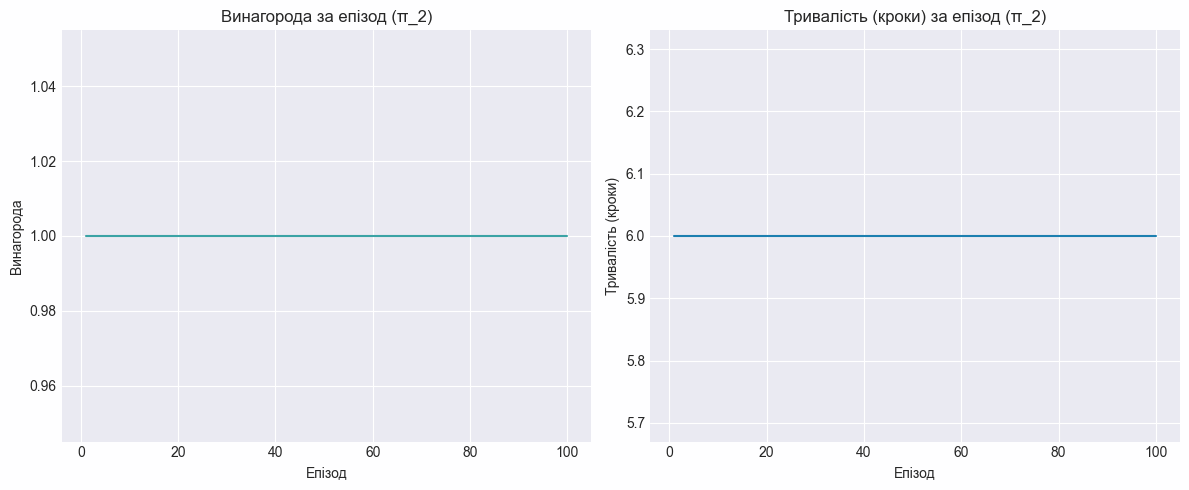

In [69]:
# Запускаємо епізоди зі стратегією π_2
pi2_rewards, pi2_episode_lengths = run_pi2_episodes(env, policy_pi2, num_episodes)

# Виводимо графіки для стратегії π_2
plot_episodes(num_episodes, 'π_2', pi2_rewards, pi2_episode_lengths)

Як можна було очікувати, стратегія $π_2$ демонструє себе настільки ж добре, як і стратегія $π_*$. Всі епізоди завершилися за 6 кроків (оптимальна і найменша кількість) із завершенням у позитивному термінальному стані. Про результати випадкової (рівноймовірної) стратегії із завдання №6 доброго слова не скажеш...